# <center>L2 Computational Physics</center>
---
## Week 4: Differential Equations II

In this notebook, you will write a program to study the trajectory of a spherical, iron cannonball in the presence of gravity and drag forces. 

In [1]:
import numpy
from matplotlib import pyplot as plt

In [2]:
# Define all constants to be used in the simulation
r_cb = 0.15  # Radius of cannonball in m
rho_iron = 7874  # Density of iron in kg/m^3
g = 9.81  # Acceleration due to gravity in m/s^2
kappa = 0.47  # Drag coefficient of a sphere
rho_air = 1.23  # Density of air in kg/m^3
v0 = 125.00  # Initial speed in m/s

From this information, calculate the following two variables:

In [3]:
def get_area(r):
    ''' 
    This function returns the cross section area of a sphere of radius r. The returned 
    value is in the squared units of the unit of the radius argument.
    '''
    return numpy.pi*numpy.power(r,2)
    raise NotImplementedError()

def get_mass(r):
    ''' 
    This function returns the mass of an iron sphere of radius r. The radius 
    should be given in meter and the return value is in kg.
    '''
    return (4/3)*numpy.pi*numpy.power(r,3)*rho_iron
    raise NotImplementedError()

area_cb = get_area(r_cb)
mass_cb = get_mass(r_cb)

In [4]:
assert numpy.isclose(area_cb, 0.07068583470577035)
assert numpy.isclose(mass_cb, 111.31605249464711)

## The Differential Equations

Create a function `f` which executes the differential equation obeyed by the cannonball's motion as it moves through the air. You should derive these equations analytically and then implement them in code.

- *Your function should accept two arguments:*
    - `r` *- a numpy array representing the cannonball's state, $(x, y, v_{x}, v_{y})$.*
    - `t` *- Time (this is needed for* `odeint`*)*
    
- *The drag force experienced by the cannonball is given by $$\vec{F}_{\textrm{d}} = - \frac{1}{2} C_{\textrm{d}} \rho |\vec{v}|^{2} A \widehat{v}~,$$ where $\widehat{v}$ is a unit vector pointing in the direction of the cannonball's instantaneous velocity.*

In [5]:
def f(r, t):
    '''Implements differential equation for cannonball from state vector r and time t'''
    
    # Unpack array of the state
    x, y, vx, vy = r
    # these variables should updated in your code to be the derivatives of 
    # the x, y positions and the derivative of the x, y velocities. 
    dx_dt, dy_dt, dvx_dt, dvy_dt = 0, 0, 0, 0
    dx_dt = vx
    dy_dt = vy
    dvx_dt = (-0.5*kappa*rho_air*(numpy.power(vy,2)+numpy.power(vx,2))*area_cb/mass_cb)*(vx/numpy.sqrt(numpy.power(vy,2)+numpy.power(vx,2)))
    dvy_dt = (-0.5*kappa*rho_air*(numpy.power(vy,2)+numpy.power(vx,2))*area_cb/mass_cb)*(vy/numpy.sqrt(numpy.power(vy,2)+numpy.power(vx,2))) - g
    return numpy.array([dx_dt, dy_dt, dvx_dt, dvy_dt])
    

Check your result:

In [6]:
r_test = [0, 0, 88.38834764831843, 88.38834764831843]
assert len(f(r_test, 0))== 4

In [7]:
r_test = [0, 0, 88.38834764831843, 88.38834764831843]
assert numpy.isclose(f(r_test, 0), [ 88.38834765,  88.38834765,  -2.0279283 , -11.8379283 ]).all()

## Solving the Differential Equations

Create the function `solve_euler(state_initial, t1, n_panels)` which solves the differential equations using Euler's method.

- `state_initial` *is a numpy array containing the initial conditions $(x_{0}, y_{0}, v_{x0}, v_{y0})$*
- *When working with a numpy array, you can use the same commands as those used for single variables - for instance,* `state += f(state, t)`.
- *This function should record all state values at each timepoint for later use. This will be similar to last week, only this time you will have to populate a 2D array.*

In [8]:
def solve_euler(state_initial, t1, n_steps):
    '''Solves ODE using Euler's method from state_initial to end time t1 using n_panels panels'''
    # Define array for trajectory history
    history = numpy.empty((n_steps+1,4))  # Number of columns is equal to number of variables to solve for (4)
    history[0] = state_initial
    # you should now populate the history array
    Timestep = t1/n_steps
    for i in range(1,n_steps+1):
        history[i]= history[i-1]+f(history[i-1],0)*Timestep
    return history


Test your solution:

In [9]:
r_test = [0, 0, 88.38834764831843, 88.38834764831843]
assert numpy.isclose(solve_euler(r_test, 25.0, 10), numpy.array(
    [[   0.        ,    0.        ,   88.38834765,   88.38834765],
     [ 220.97086912,  220.97086912,   83.3185269 ,   58.7935269 ],
     [ 429.26718637,  367.95468637,   79.41984538,   31.51743125],
     [ 627.81679983,  446.7482645 ,   76.30595276,    5.75669607],
     [ 818.58168171,  461.14000469,   73.62655732,  -18.97044366],
     [1002.64807501,  413.71389553,   71.05785323,  -42.83359748],
     [1180.2927081 ,  306.62990184,   68.35253688,  -65.72783569],
     [1351.1740503 ,  142.31031262,   65.37829955,  -87.3928075 ],
     [1514.61979917,  -76.17170612,   62.10406078, -107.54105068],
     [1669.87995113, -345.02433282,   58.56508321, -125.93786257],
     [1816.29265915, -659.86898925,   54.83262575, -142.43661744]])).all()

## Finding the range

To find the range of the projectile we will look for the x coordinate when the trajectory crosses the $y=0$ line. In most cases that point will not be one of the steos but will be between two steps. We will use a linear approximation to determine this point given the last point with a positive $y$ value and the first point with a negative $y$ value. Implement the function `find_zero_linear` that takes as argument the two values of $x$ `x1` and `x2` and the heights `y1` and `y2` and returns the value of $x$ at which the line between $(x_1,y_1)$ and $x_2,y_2$ crosses the $y=0$ line.  

In [10]:
def find_zero_linear(x1, x2, y1, y2):
    if y1*y2 > 0:
        print("I expect y1 and y2 to have opposite signs!")
    k = (y2-y1)/(x2-x1)
    return x1-y1/k
    raise NotImplementedError()

In [11]:
assert numpy.isclose(find_zero_linear(-1,1,3,-3),0.0)
assert numpy.isclose(find_zero_linear(-1,1,1,-3), -0.5)

Given the function above we can define a function to determine the range. (Don't modify it!)

In [12]:
def find_range(history):
    all_xs = history[:,0]
    all_ys = history[:,1]
    negatives = numpy.argwhere(all_ys<0)
    if len(negatives) == 0 :
        print ("The projectile did not touch down! Returning the last known location")
        return all_xs[-1]
    (index,) = negatives[0]
    y1, y2 = all_ys[index-1], all_ys[index]
    x1, x2 = all_xs[index -1], all_xs[index]
    return find_zero_linear(x1,x2,y1,y2)

In [13]:
r_test = [0, 0, 88.38834764831843, 88.38834764831843]
h = solve_euler(r_test, 25.0, 10000)
assert numpy.isclose(find_range(h),1306.2541)

## Plotting task

Create a plot to show the trajectories for different values of the initial angle. Use the same velocity $v0=125\rm{m/s}$ for all angles. The plot should have axis labels and a title.


Text(0,0.5,'y')

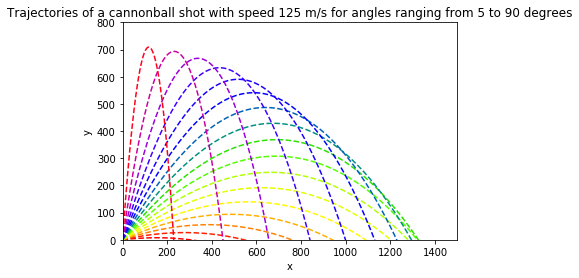

In [14]:
n_steps = 1000
thetas = range(5, 90, 5) # the angles in degrees
for i in thetas:
    initial_conditions = [0, 0, numpy.cos(2*numpy.pi*i/360)*125, numpy.sin(2*numpy.pi*i/360)*125]
    values_euler = solve_euler(initial_conditions, 300, n_steps)
    xs_euler, ys_euler = values_euler[:,0], values_euler[:,1]
    plt.plot(xs_euler, ys_euler, color= plt.cm.prism(i/900), linestyle='--')
    plt.xlim(0,1500)
    plt.ylim(0,800);
plt.title("Trajectories of a cannonball shot with speed 125 m/s for angles ranging from 5 to 90 degrees")
plt.xlabel("x")
plt.ylabel("y")

Create a plot to show the range for different values of the initial velocity. Use the same angle $\theta=60^\circ$ for all velocities. The plot should have axis labels and a title and legend. Produce one curve with and one curve without the effect of air resistance.


Text(0,0.5,'Range')

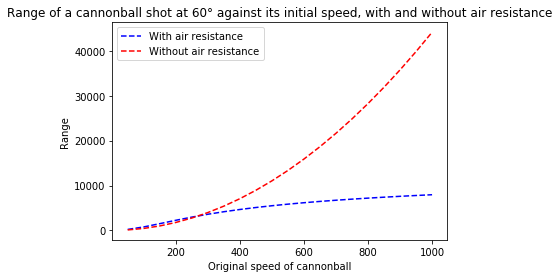

In [23]:
n_steps = 1000
max_time = 300
v0s = numpy.linspace(50, 1000, 20)
theta = numpy.deg2rad(60)
ranges = [find_range(solve_euler([0,0,(numpy.cos(theta)*x),(numpy.sin(theta))*x], max_time, n_steps)) for x in v0s]
ranges_noresistance = [((numpy.sin(theta)*numpy.cos(theta)*x**2)/9.81) for x in v0s]

plt.plot(v0s, ranges, color= 'blue', linestyle='--',label="With air resistance")
plt.plot(v0s, ranges_noresistance, color= 'red', linestyle='--',label="Without air resistance")
plt.legend(loc='best')
plt.title("Range of a cannonball shot at 60° against its initial speed, with and without air resistance")
plt.xlabel("Original speed of cannonball")
plt.ylabel("Range")
